# Overview #

Economic analyzes are important to determine the feasibility of constructing and operating any  facility. This notebook takes in the Total Capital Investment of a plant, and given projected revenues and costs calculates the Profitability Index and average ROI over a 25 year time span. A 3D graph is made to look at the sensitivity of the plant profitability with changing revenues and costs. A summary of the results is then presented.

In [1]:
# Libraries needed for plotting
import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
# Read in Cost Data
data = pd.read_csv('/ENCH 511/3D_sensitivity.csv')

In [3]:
# Sample of Cost Data
data.head()

,Year,Revenue,Costs
0,0,0.0,0.00
1,1,41629782.6,39670630.32
2,2,83259565.2,80252854.47
3,3,85166272.8,80728992.31
4,4,87072980.4,81205130.14


In [4]:
# Hard costs
tci = 31.741e6
equipment = 5.66e6
building = 7.72e5
tax_rate = 0.3
interest_rate = 0.1
depreciation_equip = 0.5
depreciation_build = 0.04

In [5]:
# Calculating depreciation
def calc_depreciation(prev_dep_build, prev_dep_equip):
    cur_build = prev_dep_build*(1-depreciation_build)
    cur_equip = prev_dep_equip*(1-depreciation_equip)
    cur_d_build = prev_dep_build*depreciation_build
    cur_d_equip = prev_dep_equip*depreciation_equip
    return [cur_build, cur_equip, cur_d_build, cur_d_equip]

In [6]:
# Calculating discounted cash flow for given year
def calc_DCF(cur_d_build, cur_d_equip, revenue, costs, year):

    return calc_CF(cur_d_build, cur_d_equip,
                   revenue, costs, year)/((1+interest_rate)**year)
    
    

In [7]:
# Calculating discounted cash flow for given year
def calc_CF(cur_d_build, cur_d_equip, revenue, costs, year):
    before_tax_profit = revenue - costs - cur_d_build - cur_d_equip
    tax_paid = before_tax_profit*tax_rate
    cash_flow = revenue - costs - cur_d_build - cur_d_equip - tax_paid
    
    return cash_flow
    

In [8]:
# Function for getting discounted and non-discounted cash
# flows over the lifetime of  the plant.
def get_dcf(data, pct_chg_rev=1, pct_chg_cost=1):
    discounted_cash_flows = [-tci]
    cash_flows = [-tci]
    for i in range(1,len(data)):
        if i ==1:
            [cur_build, cur_equip, cur_d_build, cur_d_equip]= \
                calc_depreciation(building, equipment)
            dcf = calc_DCF(
                cur_d_build, cur_d_equip,
                pct_chg_rev*data.iloc[i,1], 
                pct_chg_cost*data.iloc[i,2], i)
            cf = calc_CF(
                cur_d_build, cur_d_equip,
                pct_chg_rev*data.iloc[i,1], 
                pct_chg_cost*data.iloc[i,2], i)
        else:
            [cur_build, cur_equip, cur_d_build, cur_d_equip]= \
                calc_depreciation(cur_build, cur_equip)
            dcf = calc_DCF(
                cur_d_build,
                cur_d_equip, pct_chg_rev*data.iloc[i,1], 
                pct_chg_cost*data.iloc[i,2], i)
            cf = calc_CF(
                cur_d_build,
                cur_d_equip, pct_chg_rev*data.iloc[i,1], 
                pct_chg_cost*data.iloc[i,2], i)
            
        discounted_cash_flows.append(dcf)
        cash_flows.append(cf)
        
    return [discounted_cash_flows, cash_flows]

In [9]:
# Data for sensitivity analysis
sensitivity = []
# Changing revenues from -15% to +15%
for i in range(-15,16,1):
    # Changing costs from -15% to +15% 
    for j in range(-15,16,1):
        dcfs, cfs = get_dcf(data=data,pct_chg_rev=1+float(i)/100,
                       pct_chg_cost=1+float(j)/100)
        # Calculating NPV for a plant based on a 25 year lifetime
        NPV = sum(dcfs[:26])
        # Calculating profitability index
        PI = NPV/tci
        # Calculating ROI
        roi = 100*sum(cfs[:26])/25/tci
        sensitivity.append([i,j,round(PI,1), round(roi,1)])

In [10]:
results = pd.DataFrame(
    sensitivity,columns=["Percent Change Revenue",
                         "Percent Change Cost",
                         "Profitability Index",
                         "Averaged ROI (%)"])

In [11]:
# Sample of results
results.tail()

,Percent Change Revenue,Percent Change Cost,Profitability Index,Averaged ROI (%)
956,15,11,1.6,34.2
957,15,12,1.5,32.4
958,15,13,1.3,30.7
959,15,14,1.2,28.9
960,15,15,1.0,27.1


## Profitability Index for various percent changes in cost and revenues ##

In [12]:
# Plotting 3D graph for Profitability Index
fig = plt.figure()
ax = plt.axes(projection='3d',
              xlabel='% Change Cost',
              ylabel='% Change Revenue',
              zlabel='PI',
              zlim =(-6,6))

# Data for three-dimensional scattered points
zdata = results["Profitability Index"]
xdata = results["Percent Change Cost"]
ydata = results["Percent Change Revenue"]
ax.scatter3D(xdata, ydata, zdata, c=zdata,cmap= cm.RdYlGn);


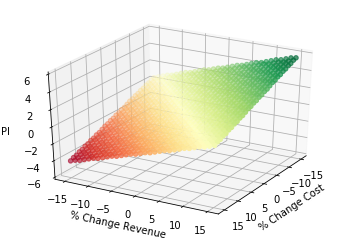

In [13]:
ax.view_init(30,30)
fig

## Average ROI for various percent changes in cost and revenues ##

In [14]:
# Plotting 3D graph for Averaged ROI
fig = plt.figure()
ax = plt.axes(projection='3d',
              xlabel='% Change Cost',
              ylabel='% Change Revenue',
              zlabel='ROI',
              zlim =(-50,100))

# Data for three-dimensional scattered points
zdata = results["Averaged ROI (%)"]
xdata = results["Percent Change Cost"]
ydata = results["Percent Change Revenue"]
ax.scatter3D(xdata, ydata, zdata, c=zdata,cmap= cm.RdYlGn);

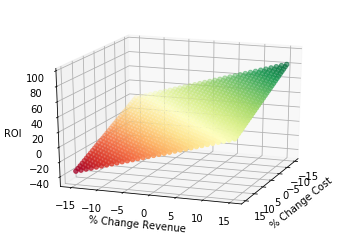

In [15]:
ax.view_init(20,20)
fig

## Summary of Results ##

In [16]:
print("Average Profitability Index (PI) is {} "
      "(>1 is profitable).".format(
    round(results["Profitability Index"].mean(),2)))

Average Profitability Index (PI) is 0.72  (>1 is profitable).


In [17]:
print("Percentage of time PI is greater than 1 is {}%.".format(
    round(float(len(
    results.loc[results["Profitability Index"]>1,:]))\
    /len(results)*100)))

Percentage of time PI is greater than 1 is 44.0%.


In [18]:
print("Average ROI over 25 year time period is {}%.".format(
    round(results["Averaged ROI (%)"].mean(),1)))

Average ROI over 25 year time period is 23.0%.


In [19]:
print("Percentage of time average ROI over 25 years"
      " is greater than 0 is {}%.".format(round(float(len(
      results.loc[results["Averaged ROI (%)"]>0,:]))\
      /len(results)*100)))

Percentage of time average ROI over 25 years is greater than 0 is 81.0%.
